# Doobydobap Channel Analysis

In [107]:
# Import libraries

import googleapiclient.discovery
import json
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# to hide developer key

import DoobydobapConfig.config as config

In [108]:
# Create youtube object

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = config.DEVELOPER_KEY

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY)

doobydobap = 'UCh8gHdtzO2tXd593_bjErWg'

In [109]:
# function uses youtube API to get specified channel data

def get_channel_data(youtube, channel):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel
    )
    response = request.execute()
    return response

In [ ]:
# get dooby channel stats and pretty print json output

dooby_stats = get_channel_data(youtube, doobydobap)

print(json.dumps(dooby_stats, indent=4, sort_keys=True))

In [111]:
# retrieve key for all of dooby's uploads

dooby_uploads_key = dooby_stats['items'][0]['contentDetails']['relatedPlaylists']['uploads']

In [112]:
# function gets all video keys from uploads playlist

def get_dooby_videos(youtube, playlistId):
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=playlistId,
        maxResults = 50
    )
    response = request.execute()
    video_ids = []
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part="contentDetails",
                playlistId=playlistId,
                maxResults = 50,
                pageToken = next_page_token
            )
            
            response = request.execute()
            
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
                
            next_page_token = response.get('nextPageToken')

    return video_ids

In [ ]:
# create array with all video ids

dooby_video_ids = get_dooby_videos(youtube, dooby_uploads_key)

print(json.dumps(dooby_video_ids, indent=1))

In [114]:
# gets specified data about all videos passed

def get_dooby_video_stats(youtube, video_ids):
    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet,statistics,contentDetails',
            id=",".join(video_ids[i:i+50])
        )
        
        response = request.execute()
        
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Date_published = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount'],
                               Duration = video['contentDetails']['duration'])
            all_video_stats.append(video_stats)
    
    return all_video_stats

In [ ]:
# create dictionary with all video data

dooby_video_stats = get_dooby_video_stats(youtube, dooby_video_ids)

print(json.dumps(dooby_video_stats, indent=4, sort_keys=True))

In [116]:
# create dataframe

dooby_df = pd.DataFrame(dooby_video_stats)

dooby_df

,Title,Date_published,Views,Likes,Comments,Duration
0,The Muffin Man,2022-03-12T00:28:40Z,268056,12082,828,PT17M32S
1,Flying to London,2022-03-09T22:27:43Z,425565,18581,1279,PT17M58S
2,What I ate Flying Business Class Korean Air 🇰🇷...,2022-03-08T07:38:14Z,2446424,252281,1315,PT58S
3,(not so) Teenage Angst,2022-03-02T16:26:23Z,411199,18261,1393,PT22M56S
4,can't smell :s,2022-02-26T15:12:43Z,316955,14736,1240,PT14M35S
...,...,...,...,...,...,...
138,"KOREAN STREET FOOD VLOG #1// Gwangjang Market,...",2021-04-18T18:30:09Z,317550,11848,432,PT10M38S
139,CHILI OIL BIANG BIANG NOODLES,2021-04-03T22:11:29Z,1392626,84313,571,PT50S
140,Chorizo Kimchi Fried Rice,2021-03-27T00:10:14Z,130000,5615,161,PT6M59S
141,Tonkotsu Ramen - Behind the Scenes,2021-02-27T01:21:44Z,223063,8791,345,PT8M40S


In [117]:
# check data types

dooby_df.dtypes

Title             object
Date_published    object
Views             object
Likes             object
Comments          object
Duration          object
dtype: object

In [118]:
# convert all data types to data types that accurately reflect data and add year and month column

dooby_df['Title'] = dooby_df['Title'].astype("string")

dooby_df['Date_published'] = pd.to_datetime(dooby_df['Date_published']).dt.date

dooby_df['Views'] = pd.to_numeric(dooby_df['Views'])

dooby_df['Likes'] = pd.to_numeric(dooby_df['Likes'])

dooby_df['Comments'] = pd.to_numeric(dooby_df['Comments'])

dooby_df['Duration'] = dooby_df['Duration'].astype("string")

dooby_df['year'] = pd.DatetimeIndex(dooby_df['Date_published']).year

dooby_df['month'] = pd.DatetimeIndex(dooby_df['Date_published']).month

In [119]:
# check to make sure it worked

dooby_df.dtypes

Title             string
Date_published    object
Views              int64
Likes              int64
Comments           int64
Duration          string
year               int64
month              int64
dtype: object

In [120]:
# make a copy so any original dataframe is preserved

normalized_dooby_df = dooby_df.copy()

In [121]:
# function to normalize data with min max scaling

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

In [122]:
# normalize numerical data columns

normalized_dooby_df['Views'] = min_max_scaling(normalized_dooby_df['Views'])

normalized_dooby_df['Likes'] = min_max_scaling(normalized_dooby_df['Likes'])

normalized_dooby_df['Comments'] = min_max_scaling(normalized_dooby_df['Comments'])

In [123]:
# also going to convert duration column to just numbers so can do something with it

def convert_to_digits(series):
    new_string = ""
    for c in series:
        if c.isdigit():
            new_string += c
    return new_string

In [124]:
normalized_dooby_df["Duration"] = normalized_dooby_df["Duration"].apply(convert_to_digits)

normalized_dooby_df["Duration"] = pd.to_numeric(normalized_dooby_df["Duration"])

normalized_dooby_df['Duration'] = min_max_scaling(normalized_dooby_df['Duration'])

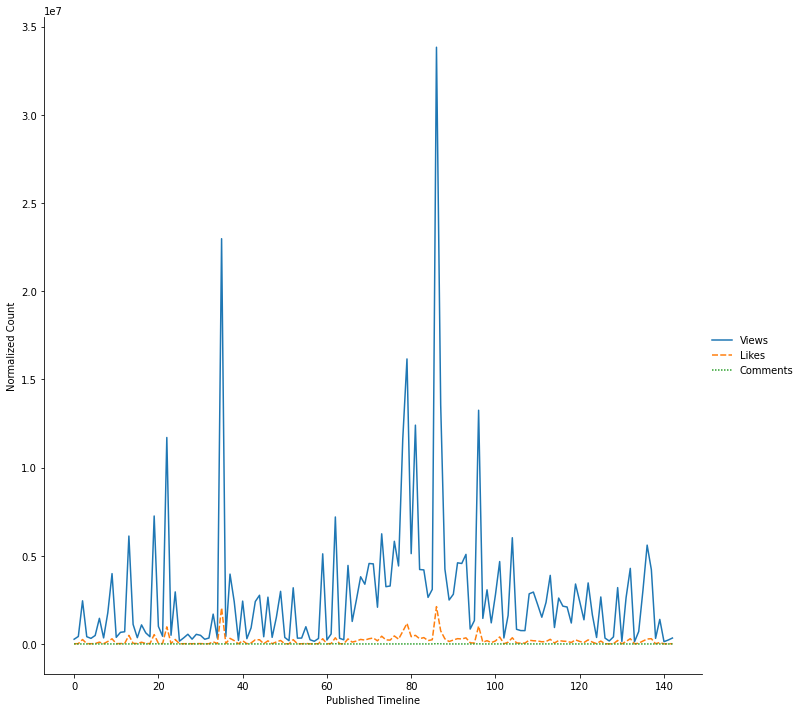

In [125]:
# graph of unmodified data, as you can see views dwarfs other data

regular_graph = sns.relplot(data=dooby_df[['Views', 'Likes', 'Comments']], kind="line", height=10)

regular_graph.set(xlabel="Published Timeline", ylabel="Normalized Count")

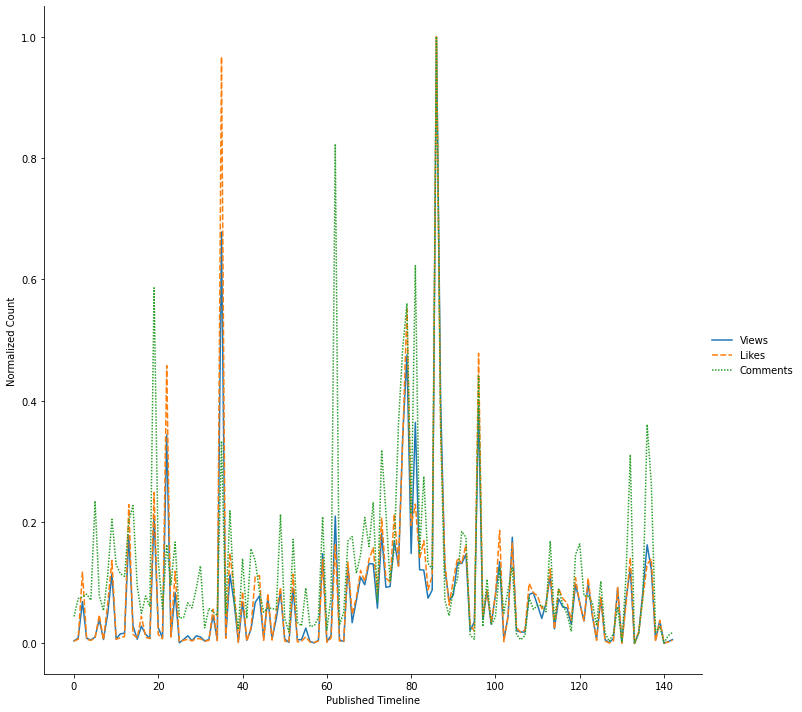

In [126]:
# graph of normalized data to get a better idea of how stuff is performing with each other

normalized_graph = sns.relplot(data=normalized_dooby_df[['Views', 'Likes', 'Comments']], kind="line", height=10)

normalized_graph.set(xlabel="Published Timeline", ylabel="Normalized Count")

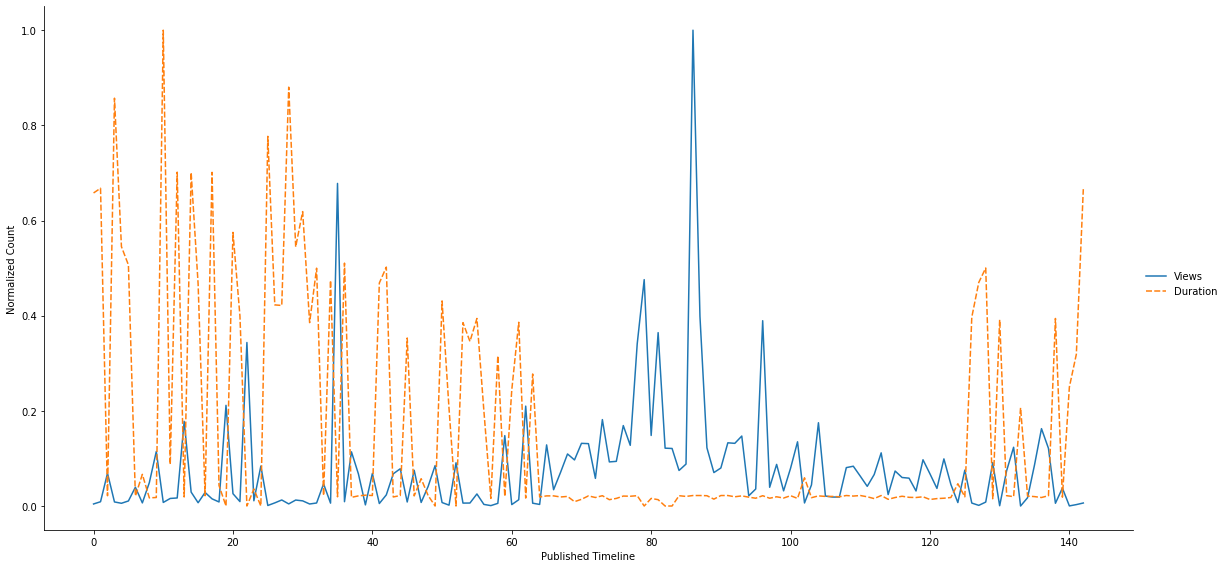

In [127]:
# graph to show relationship between views and duration

normalized_graph = sns.relplot(data=normalized_dooby_df[['Views', 'Duration']], kind="line", height=8, aspect=2)

normalized_graph.set(xlabel="Published Timeline", ylabel="Normalized Count")

In [128]:
dooby_df.sort_values('Views', ascending=False).head(20)

,Title,Date_published,Views,Likes,Comments,Duration,year,month
86,Do You Ever Dream About.. Chili Oil Ramen?,2021-09-27,33825543,2116930,15472,PT59S,2021,9
35,Nostalgia is a powerful ingredient,2021-11-30,22972358,2047174,5259,PT52S,2021,11
79,What I Ate for Lunch in 7/11 Korea,2021-10-06,16157354,1166921,8737,PT1M,2021,10
87,GARLIC WHOLE FRIED CHICKEN,2021-09-24,13552740,744066,5602,PT59S,2021,9
96,This is what I ate in a gas stop in Korea,2021-09-06,13248356,1014531,6902,PT58S,2021,9
81,My biggest fear when posting content,2021-10-05,12403912,488998,9687,PT36S,2021,10
22,Cadaver Dissection,2022-01-05,11703747,971561,2640,PT1M,2022,1
78,I can't believe that I didn't want this before,2021-10-07,11619864,711422,7610,PT58S,2021,10
19,Deal Breakers,2022-01-12,7254032,529652,9129,PT1M,2022,1
62,"How I stay ""skinny""",2021-10-22,7198553,350483,12764,PT45S,2021,10


In [129]:
dooby_df.sort_values('Views').head(20)

,Title,Date_published,Views,Likes,Comments,Duration,year,month
133,KOREAN STREET FOOD VLOG #2 l Noryangjin Fish M...,2021-05-29,123437,3857,146,PT5M44S,2021,5
140,Chorizo Kimchi Fried Rice,2021-03-27,130000,5615,161,PT6M59S,2021,3
130,KOREAN STREET FOOD VLOG #3 | Jeju 5 Day Market,2021-06-05,142599,5217,172,PT10M31S,2021,6
57,Moody & Tacos l NYC Vlog,2021-10-28,151870,7472,595,PT4M3S,2021,10
25,21 lessons from 2021 l Craziest year so far,2021-12-31,160431,10844,792,PT20M45S,2021,12
127,Corn Rice and Miso Soup,2021-06-18,169516,5351,200,PT12M37S,2021,6
51,"Second to Last Day-- empanadas, estella, and a...",2021-11-07,184653,7083,437,PT5M39S,2021,11
39,"Seoul Vlog - brunch, my first interview, eatin...",2021-11-24,202970,7630,495,PT6M1S,2021,11
141,Tonkotsu Ramen - Behind the Scenes,2021-02-27,223063,8791,345,PT8M40S,2021,2
60,Eating at Hip n Cool Restos l NYC Vlog,2021-10-25,223821,8054,482,PT6M42S,2021,10
